In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
import numpy as np
import scipy as sc
from scipy.optimize import curve_fit 

# Part 1: Measuring Gain and Read Noise

In [2]:
bias = []
lamp60 = []
lamp121 = []
lamp242 = []

#We have a set of files from our observations at three varying temperatures. The below for-loop uses the
#consistency in their nomenclature to store each file in a list
for i in range(1,11):
    bias.append(fits.getdata("Bias-"+"0"*(4-len(str(i)))+str(i)+".fit", ext=0).astype(np.int))
    lamp60.append(fits.getdata("Lamp60-"+"0"*(4-len(str(i)))+str(i)+".fit", ext=0).astype(np.int))
    lamp121.append(fits.getdata("Lamp121-"+"0"*(4-len(str(i)))+str(i)+".fit", ext=0).astype(np.int))
    lamp242.append(fits.getdata("Lamp242-"+"0"*(4-len(str(i)))+str(i)+".fit", ext=0).astype(np.int))

In [3]:
#This transforms the list into an array
bias = np.asarray(bias)

In [4]:
#This is a nice way to make sure the above line executed properly. It gives the size of the array along each dimension
bias.shape

(10, 2504, 3326)

In [5]:
#This gives us the average bias (still an array of 2D values) along a plane in our 3D array (we know it is 3D because
#of the output of the shape function in the line above). That is why we fix it to the 0 axis
bbar = bias.mean(axis=0)

In [6]:
#We check to make sure our output is a two dimensional array as expected
print(bbar)

[[ 994.4  984.7  982.3 ...  982.9  979.9  978.4]
 [ 991.6  996.1  993.1 ...  990.2  988.8  973. ]
 [ 981.3  980.3  992.  ...  987.8  977.7  984.5]
 ...
 [ 996.7  987.5  996.8 ...  988.7  993.2  996.3]
 [ 999.   995.8  991.8 ...  994.3 1009.8  990. ]
 [ 993.8  995.6 1008.2 ...  983.3 1003.1 1006.3]]


In [7]:
#We repeat these steps (transforming list into array and checking the shape) for each of our data files
lamp60 = np.asarray(lamp60)

In [8]:
lamp60.shape

(10, 2504, 3326)

In [9]:
f60 = (lamp60-bbar)
f60mean = f60.mean()
f60var = np.var(f60, axis =0)
f60varmean = np.mean(np.var(f60, axis =0))

#We expect the mean to be a single value
print(f60mean)

#We expect the variance to be a two dimensional array of values
print(f60var)

#We can make the above two dimensional array a single value by taking the mean of it along the 0 axis
print(f60varmean)

1926.0478603086494
[[2380.69 4076.09 3244.8  ... 3529.89 3361.81 1810.44]
 [8573.61 1969.05 1466.29 ... 5016.04 5967.41 1063.6 ]
 [4374.09 3489.49 5249.89 ... 5418.56 6008.09 2107.85]
 ...
 [5285.69 1728.81 5265.69 ... 1657.29 4828.36 3868.36]
 [1894.49 2859.76 2062.65 ... 1686.04 1514.64 3159.41]
 [4432.89 1969.64 7090.29 ... 4051.05 6134.45 6418.24]]
4067.5900097642957


In [10]:
lamp121 = np.asarray(lamp121)

In [11]:
lamp121.shape

(10, 2504, 3326)

In [12]:
#We repeat the steps from lamp60 for lamp120 and lamp242
f121 = (lamp121-bbar)
f121mean = f121.mean()
f121var = np.var(f121, axis =0)
f121varmean = np.mean(np.var(f121, axis =0))
print(f121mean)
print(f121var)
print(f121varmean)

9371.133222238283
[[26494.84 24231.56 23820.01 ... 16089.4  20001.6  28854.61]
 [16878.44 14483.85  9631.29 ... 35149.8  28873.04 18594.69]
 [10284.49 15033.61 11976.85 ... 20120.44 26030.96 23999.41]
 ...
 [17460.29  4031.49 26872.6  ... 27196.64  8547.21 31954.36]
 [29807.56 12808.69 12740.44 ...  9841.41 15692.04  7399.56]
 [19161.29 25303.24 22641.01 ... 26864.36 40079.6   6024.81]]
19169.588255619637


In [13]:
lamp242 = np.asarray(lamp242)
lamp242.shape

(10, 2504, 3326)

In [14]:
f242 = (lamp242-bbar)
f242mean = f242.mean()
f242var = np.var(f242, axis =0)
f242varmean = np.mean(np.var(f242, axis =0))
print(f242mean)
print(f242var)
print(f242varmean)

27898.666591805406
[[ 21196.2   54727.04  47367.69 ...  80044.49  31564.81  32350.8 ]
 [ 45001.6   26293.49  60284.21 ...  79419.36  57015.64  39680.61]
 [ 62015.84  79325.44  35566.84 ...  50805.4   15836.29  75541.05]
 ...
 [ 69774.16  19064.61  41548.61 ...  65378.2   52748.4   55082.04]
 [ 33699.96  11625.69  35747.24 ...  28022.2   24253.76  82406.65]
 [ 28062.36  38253.49  29451.8  ...  78992.89 110332.81  41059.49]]
56629.258027756914


In [15]:
#We note that since none of the groups collected data for this portion with variable exposure times, we are 
#unable to construct a plot todetermine if the detector has a non-linear relationship between the signal and 
#exposure time

Gain Calculation

In [16]:
xvals = [f60mean, f121mean, f242mean]
yvals = [f60varmean, f121varmean, f242varmean]
#We assume that the gain function can be approximated by a linear equation in the form y = ax+b
#We seek to graph our points as a scatter plot and run a regression to find the average value of
#Mean/Variance of the Mean. This will give us the gain for the detector

def func(x,a,b):
    return a*x+b

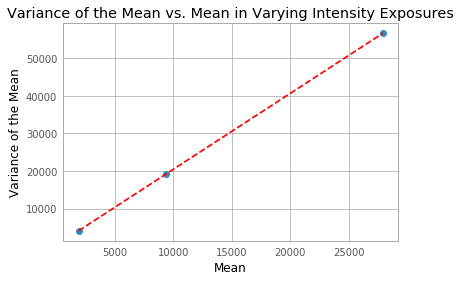

0.4942247006335683


In [17]:
#Using 'o' is a shortcut to make the chart a scatter plot
plt.plot(xvals, yvals, 'o')

#We then manually fit the curve to the data to obtain a viable set of starting parameters. We make a guess
#that our slope will be 1/2 and that there will be no intercept
at,bt = (0.5,0.00)

coeffs, fiterr = curve_fit(func, xvals, yvals, p0=(at,bt))
plt.plot(xvals, func(np.asarray(xvals),*coeffs), 'r--')
plt.title("Variance of the Mean vs. Mean in Varying Intensity Exposures")
plt.xlabel("Mean")
plt.ylabel("Variance of the Mean")
plt.show()

#We choose one over this coefficient to find the gain of the detector
print(1/coeffs[0])

Read Noise Calculation

In [25]:
#The gain is shown below, as the slope of the graph above
gain = 1/coeffs[0]
print(gain)

0.4942247006335683


In [37]:
#The read noise is shown below, as a function of the gain according to the formula provided in the Lab 4 folder 
#on canvas
rnoise = gain*bias.std(axis=0).mean()
print(rnoise)

9.605658018050281


# Part 2: Dark Current

In [20]:
#We make a second array for the bias in our second day of observing 
bias2 = []

#Once again, all of the file names are in the same format and can be stored in a list with this for loop
for i in range (1,21):
    bias2.append(fits.getdata("Bias2-"+"0"*(4-len(str(i)))+str(i)+".fit", ext=0).astype(np.int))

#Unfortunately, there were not enough similarities with the data from other groups to construct a for loop
#that would be time effective in storing the data into a list. Therefore, we manually enter the names into 
#the below variables that are later converted to an array
dark1 = fits.getdata("GroupADarkT4.6Exp450.fit")
dark2 = fits.getdata("GroupADarkT8.9Exp300.fit")
dark3 = fits.getdata("GroupBDarkT6Exp300.fit")
dark4 = fits.getdata("GroupBDarkT9Exp600.fit")
dark5 = fits.getdata("GroupCDarkT7.1Exp400.fit")
dark6 = fits.getdata("GroupCDarkT9.4Exp300.fit")
dark7 = fits.getdata("GroupDDarkT7Exp600.fit")
dark8 = fits.getdata("GroupDDarkT9.4Exp300.fit")
dark9 = fits.getdata("GroupBBDarkT8Exp400.fit")
dark10 = fits.getdata("GroupBBDarkT7Exp400.fit")
dark11 = fits.getdata("GroupAADark_Day_2_9cexp300-0001.fit")
dark12 = fits.getdata("GroupAADark_Day_2_6cexp900-0001.fit")

In [21]:
#We convert our dark current bias to an array
bias2 = np.asarray(bias2)

#We confirm its dimensions below
print(bias2.shape)

#We make a two dimensional mean of the array about the 0 axis
bbbar = bias2.mean(axis=0)

(20, 2504, 3326)


In [22]:
#Below we subtract the bias from each dark current measurement and find the median dark current over 
#a one second exposure

#Dark current 1 - 4.6C for 450 seconds
darkc1 = (dark1-bbbar)
darkc1med = np.median(darkc1)/450

#Dark current 2 - 8.9C for 300 seconds
darkc2 = (dark2-bbbar)
darkc2med = np.median(darkc2)/300

#Dark current 3 - 6C for 300 seconds
darkc3 = (dark3-bbbar)
darkc3med = np.median(darkc3)/300

#Dark current 4 - 9C for 600 seconds
darkc4 = (dark4-bbbar)
darkc4med = np.median(darkc4)/600

#Dark current 5 - 7C for 400 seconds
darkc5 = (dark5-bbbar)
darkc5med = np.median(darkc5)/400

#Dark current 6 - 9C for 300 seconds
darkc6 = (dark6-bbbar)
darkc6med = np.median(darkc6)/300

#Dark current 7 - 7C for 600 seconds
darkc7 = (dark7-bbbar)
darkc7med = np.median(darkc7)/600

#Dark current 8 - 9.4C for 300 seconds
darkc8 = (dark8-bbbar)
darkc8med = np.median(darkc8)/300

#Dark current 9 - 8C for 400 seconds
darkc9 = (dark9-bbbar)
darkc9med = np.median(darkc9)/400

#Dark current 10 - 7C for 400 seconds
darkc10 = (dark10-bbbar)
darkc10med = np.median(darkc10)/400

#Dark current 11 - 9C for 300 seconds
darkc11 = (dark11-bbbar)
darkc11med = np.median(darkc11)/300

#Dark current 12 - 6C for 900 seconds
darkc12 = (dark12-bbbar)
darkc12med = np.median(darkc12)/900

#We now convert our temperatures to K values and place them in ascending order in a list
#function that does this conversion for each
def ck (c):
    k = c + 273.15
    return k

#We test the function for T = 6C
print(ck(6))

#Seeing that the function works, we now construct our x-values list. 
xvals1 = [ck(4.6), ck(6), ck(6), ck(7), ck(7), ck(7), ck(8), ck(8.9), ck(9), ck(9), ck(9), ck(9.4)]
print(xvals1)

#We now put them in order from lowest to highest temperature and place them in a list. We double check that each y-value accurately matches up
#to the correct temperature x in the x-values list
yvals1 = [darkc1med, darkc3med, darkc12med, darkc5med, darkc7med, darkc12med, darkc9med, darkc2med, darkc11med, darkc6med, darkc4med, darkc8med]

#We print our y-values to see what limits to set on the plot
print(yvals1)

279.15
[277.75, 279.15, 279.15, 280.15, 280.15, 280.15, 281.15, 282.04999999999995, 282.15, 282.15, 282.15, 282.54999999999995]
[0.17044444444444454, 0.1828333333333334, 0.17300000000000004, 0.1894999999999999, 0.1789166666666667, 0.17300000000000004, 0.184375, 0.22666666666666666, 0.22516666666666652, 0.22916666666666666, 0.22541666666666665, 0.21883333333333327]


In [40]:
#We now convert the y-values list and x-values list into arrays

yvals1 = np.asarray(yvals1)
xvals1 = np.asarray(xvals1)

#We now multiply the yvals array by the Gain to convert from ADUs to electrons
yvals2 = gain*yvals1
print (yvals2)

[0.08423785 0.09036075 0.08550087 0.09365558 0.08842504 0.08550087
 0.09112268 0.11202427 0.11128293 0.11325983 0.11140648 0.10815284]


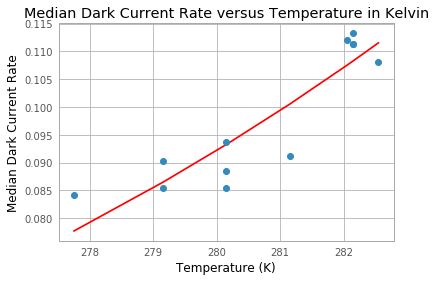

('Calculated Band Gap = ', 0.9684692854807712)
('Dark Current Coefficient = ', 174114.42970394104)
Band Gap of Silicon = 1.14


In [41]:
#Below we have the function that shows how dark current varies according to temperature
def darkcurrentfxn (T,E,A):
    return A*T**(3/2)*np.exp(-E/(2*(8.61*10**(-5))*T))

#The below is our guess for the intercept and the slope of our regression
E0,A0 = (0.5,140)
coeffss, fiterr = curve_fit(darkcurrentfxn, xvals1, yvals2, p0=(E0,A0))
plt.plot(xvals1,darkcurrentfxn(np.array(xvals1),*coeffss),'r')

plt.plot(xvals1,yvals2, 'o')
plt.title('Median Dark Current Rate versus Temperature in Kelvin')
plt.xlabel("Temperature (K)")
plt.ylabel("Median Dark Current Rate")
plt.show()
print('Calculated Band Gap = ', coeffss[0])
print('Dark Current Coefficient = ', coeffss[1])
print('Band Gap of Silicon = 1.14')

#We note from the below graph that the line is slightly curved, which is what we hope to see
#in the plot given that the equation we have set the curve to fit is proportional to T raised to the 3/2 power